## A: Setup and Local Fit Score Definition

This script sets up the environment, imports necessary libraries (Pillow, NumPy, Matplotlib), and defines the `calculate_edge_diff` function. This function serves as the **local fit score**, measuring the quality of the fit between two pieces along a shared edge using the Sum of Squared Differences (SSD) of pixel values. A lower SSD value indicates a better fit.

In [75]:
# Code A: Setup and Local Fit Score (Updated Config)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import itertools

# --- CONFIGURATION (Updated Hyperparameters) ---
IMAGE_PATH = '/content/baboon.jpg' # Upload an image named this
N_ROWS = 4
N_COLS = 4
POPULATION_SIZE = 150  # Increased
GENERATIONS = 300      # Increased
EPSILON = 1e-6         # Small constant for fitness calculation
# --- END CONFIGURATION ---

# Image Loading and Piece Generation (Helper for Fit Score)
def generate_pieces(image_path, rows, cols):
    """Loads image, resizes it, and splits it into rectangular pieces."""
    try:
        img = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: {image_path} not found. Please upload a sample image.")
        return None

    width, height = img.size
    piece_width = width // cols
    piece_height = height // rows

    img = img.crop((0, 0, piece_width * cols, piece_height * rows))

    pieces = []
    for r in range(rows):
        for c in range(cols):
            left = c * piece_width
            top = r * piece_height
            right = left + piece_width
            bottom = top + piece_height
            piece = np.array(img.crop((left, top, right, bottom)), dtype=np.float32)
            pieces.append(piece)

    return pieces

# Local Fit Score Definition (Requirement a) - SSD Misfit
def calculate_edge_diff(piece1, piece2, edge):
    """
    Calculates the Sum of Squared Differences (SSD) between two edges (Misfit).
    LOWER difference means a BETTER fit.
    Edge mapping: 1=Right-Left pairing, 2=Bottom-Top pairing
    """
    if edge == 1: # Piece 1's Right edge vs Piece 2's Left edge
        edge1 = piece1[:, -1, :]
        edge2 = piece2[:, 0, :]
    elif edge == 2: # Piece 1's Bottom edge vs Piece 2's Top edge
        edge1 = piece1[-1, :, :]
        edge2 = piece2[0, :, :]
    else:
        return np.inf

    ssd = np.sum((edge1 - edge2)**2)
    return ssd

pieces = generate_pieces(IMAGE_PATH, N_ROWS, N_COLS)
if pieces:
    N_PIECES = len(pieces)
    print(f"Puzzle pieces generated. Local fit score defined. Config updated.")

Puzzle pieces generated. Local fit score defined. Config updated.


## B: Overall Fitness Evaluation

This section defines the `calculate_fitness` function, which computes the overall fitness for a complete puzzle arrangement. It sums the pre-calculated (and negated) edge difference scores for all horizontally (right-left) and vertically (bottom-top) adjacent pieces in the current arrangement. The local misfit (SSD) is negated so that **higher scores indicate better assemblies**.

In [76]:
# Code B: Overall Fitness Evaluation (Improved Formula)

# Assuming pieces and global constants are available from Code A
if 'pieces' not in locals() or pieces is None or 'EPSILON' not in locals():
    print("Error: Required variables (pieces, EPSILON) are missing. Run Code A first.")
else:
    # Pre-calculating and Transforming Edge Differences for ADJACENCY Matrix
    # Transformation: Fitness = 1 / (SSD + EPSILON) -> HIGHER score is BETTER.
    ADJACENCY = np.zeros((N_PIECES, N_PIECES, 2)) # 0=Right-Left, 1=Bottom-Top

    def calculate_edge_diff_helper(p1, p2, edge_type):
        """Helper to call calculate_edge_diff and return transformed fitness."""
        ssd = calculate_edge_diff(p1, p2, edge_type)
        return 1.0 / (ssd + EPSILON) # Inverse SSD transformation

    for i, j in itertools.product(range(N_PIECES), repeat=2):
        if i == j: continue

        # Piece i on the LEFT of Piece j (Right-Left fit)
        ADJACENCY[i, j, 0] = calculate_edge_diff_helper(pieces[i], pieces[j], 1)

        # Piece i on the TOP of Piece j (Bottom-Top fit)
        ADJACENCY[i, j, 1] = calculate_edge_diff_helper(pieces[i], pieces[j], 2)

    # Overall Fitness Evaluation (Requirement b) - Uses Inverse SSD
    def calculate_fitness(arrangement, adjacency_matrix, rows, cols):
        """
        Calculates the overall fitness for a complete arrangement by summing all
        internal adjacent edge scores (Inverse SSD).
        """
        total_fitness = 0
        n_pieces = len(arrangement)

        for i in range(n_pieces):
            r = i // cols
            c = i % cols
            current_piece = arrangement[i]

            # Check right neighbor
            if c < cols - 1:
                right_piece = arrangement[i + 1]
                total_fitness += adjacency_matrix[current_piece, right_piece, 0]

            # Check bottom neighbor
            if r < rows - 1:
                bottom_piece = arrangement[i + cols]
                total_fitness += adjacency_matrix[current_piece, bottom_piece, 1]

        return total_fitness

    # Example usage: Evaluate a random arrangement
    random_arrangement = np.arange(N_PIECES)
    np.random.shuffle(random_arrangement)

    initial_fitness = calculate_fitness(random_arrangement, ADJACENCY, N_ROWS, N_COLS)
    print(f"ADJACENCY matrix calculated using Inverse SSD.")
    print(f"Fitness of a random arrangement: {initial_fitness:.2f}")

ADJACENCY matrix calculated using Inverse SSD.
Fitness of a random arrangement: 0.00


##  C: Selection Mechanism (Survival of the Fittest)

This code defines the `selection` function, which implements the **Tournament Selection** mechanism. In this method, a small group of individuals is randomly sampled from the population, and the individual with the highest fitness score within that group (the tournament winner) is chosen as a parent for the next generation. This ensures that fitter arrangements are preferentially selected.

In [77]:
# Code C: Survival of the Fittest (Selection)

# Survival of the Fittest (Requirement c) - Tournament Selection
def selection(population, fitnesses, k=3):
    """
    Uses Tournament Selection (k=5) to choose a parent.
    Higher fitness individuals win.
    """
    # Combine population and fitnesses, then sample k individuals
    population_with_fitness = list(zip(population, fitnesses))
    tournament_members = random.sample(population_with_fitness, k)

    # The individual with the highest fitness wins the tournament
    winner = max(tournament_members, key=lambda x: x[1])[0]
    return winner

if 'ADJACENCY' in locals():
    # Example usage (Simulated population)
    simulated_population = []
    for _ in range(POPULATION_SIZE):
        ind = np.arange(N_PIECES)
        np.random.shuffle(ind)
        simulated_population.append(ind.tolist())

    simulated_fitnesses = [calculate_fitness(ind, ADJACENCY, N_ROWS, N_COLS) for ind in simulated_population]

    parent = selection(simulated_population, simulated_fitnesses, k=3)
    print(f"Tournament Selection defined (k=3).")

Tournament Selection defined (k=3).


##  D: Evolutionary Engine and Results

This is the main block that integrates all GA components: initialization of a random population, the evolution loop using the defined `selection` (C), `ordered_crossover`, and `swap_mutation` operators. It runs for a set number of generations, tracks the best fitness over time, visualizes the final solved (or best-found) arrangement, and plots the fitness progression curve.

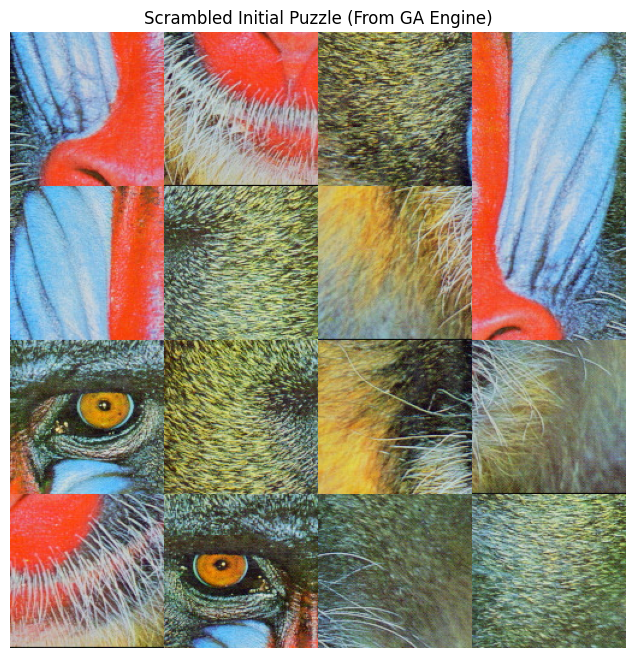


--- Starting Genetic Evolution with Informed Mutation ---
Generation 30/300: Best Fitness = 0.00013764059
Generation 60/300: Best Fitness = 0.00015025278
Generation 90/300: Best Fitness = 0.00015025278
Generation 120/300: Best Fitness = 0.00015025278
Generation 150/300: Best Fitness = 0.00015025278
Generation 180/300: Best Fitness = 0.00015025278
Generation 210/300: Best Fitness = 0.00015025278
Generation 240/300: Best Fitness = 0.00015025278
Generation 270/300: Best Fitness = 0.00015025278
Generation 300/300: Best Fitness = 0.00015025278


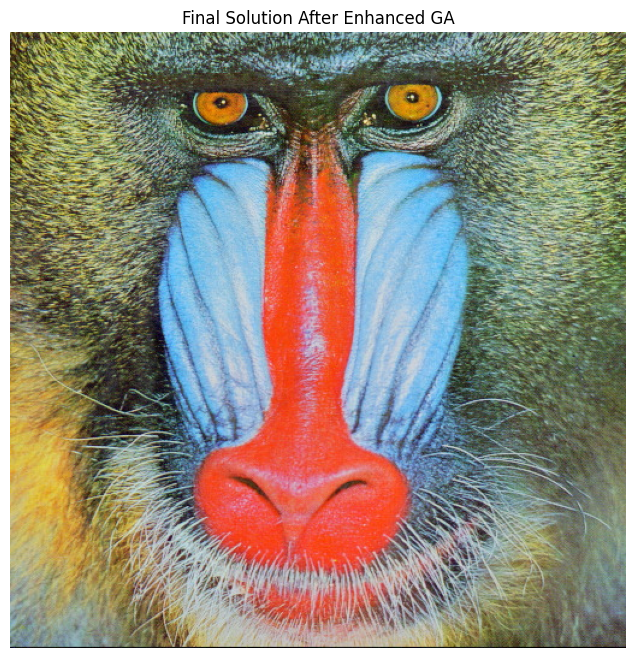

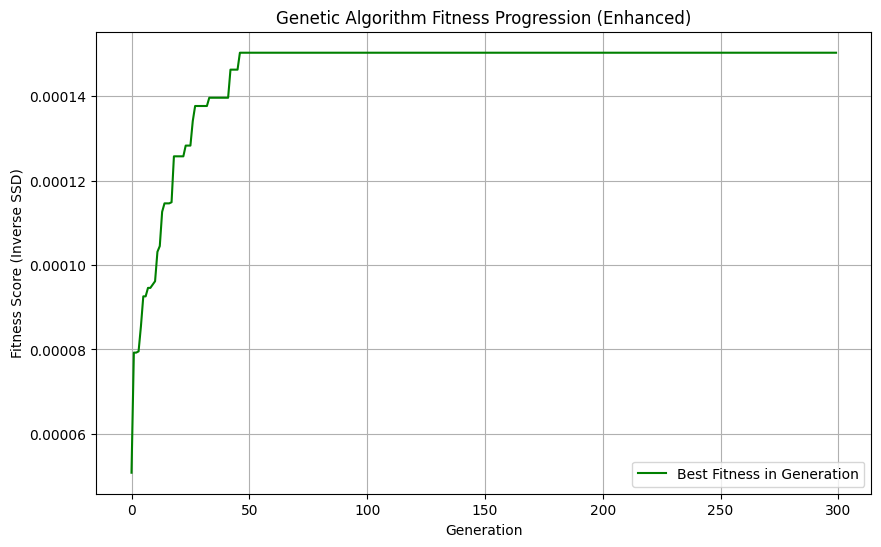

In [78]:
# Code D: Evolutionary Engine with Informed Mutation, Solution, and Plotting (MODIFIED)

# --- Genetic Operators ---
def ordered_crossover(parent1, parent2):
# ... (بدنه تابع ordered_crossover بدون تغییر) ...
    size = len(parent1)
    a, b = random.sample(range(size), 2)
    start, end = min(a, b), max(a, b)

    child = np.full(size, -1, dtype=int)
    child[start:end+1] = parent1[start:end+1]

    fill_pieces = [p for p in parent2 if p not in child]

    p2_index = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = fill_pieces[p2_index]
            p2_index += 1

    return child.tolist()

# Informed Mutation (Improved Operator)
def informed_mutation(individual, adjacency, rows, cols, mutation_rate=0.25):
# ... (بدنه تابع informed_mutation بدون تغییر) ...
    if random.random() >= mutation_rate:
        return individual

    n_pieces = len(individual)

    # 1. Find the WORST position in the current arrangement
    min_local_fit = np.inf
    worst_position_idx = -1

    for i in range(n_pieces):
        r = i // cols
        c = i % cols
        current_piece = individual[i]
        local_fit = 0

        # Check right neighbor
        if c < cols - 1:
            right_piece = individual[i + 1]
            local_fit += adjacency[current_piece, right_piece, 0]

        # Check bottom neighbor
        if r < rows - 1:
            bottom_piece = individual[i + cols]
            local_fit += adjacency[current_piece, bottom_piece, 1]

        # Check left neighbor
        if c > 0:
            left_piece = individual[i - 1]
            local_fit += adjacency[left_piece, current_piece, 0] # Adjacency is (left, right, 0)

        # Check top neighbor
        if r > 0:
            top_piece = individual[i - cols]
            local_fit += adjacency[top_piece, current_piece, 1] # Adjacency is (top, bottom, 1)

        if local_fit < min_local_fit:
            min_local_fit = local_fit
            worst_position_idx = i

    # 2. Find the piece that MAXIMIZES the local fit at this worst position
    # ... (بقیه منطق پیدا کردن بهترین جایگزین) ...

    best_swap_piece_idx = -1
    max_swap_improvement = -np.inf

    # Iterate through all other positions (pieces) to find the best swap
    for j in range(n_pieces):
        if i == j: continue

        # 3. Calculate fitness if piece at worst_position_idx is swapped with piece at j
        temp_individual = list(individual)
        temp_individual[worst_position_idx], temp_individual[j] = temp_individual[j], temp_individual[worst_position_idx]

        # Calculate the full fitness for comparison:
        current_improvement = calculate_fitness(temp_individual, adjacency, rows, cols) - calculate_fitness(individual, adjacency, rows, cols)

        if current_improvement > max_swap_improvement:
            max_swap_improvement = current_improvement
            best_swap_piece_idx = j

    # 4. Perform the best swap found
    # تغییر شرط نهایی در informed_mutation
    if best_swap_piece_idx != -1: # شرط حذف max_swap_improvement > 0
        individual[worst_position_idx], individual[best_swap_piece_idx] = individual[best_swap_piece_idx], individual[worst_position_idx]

    return individual

# Visualization function (فرض بر این است که از Code A فراخوانی شده، اما برای اطمینان تکرار می‌کنیم)
def visualize_arrangement(arrangement, pieces, rows, cols, title="Puzzle Arrangement"):
# ... (بدنه تابع visualize_arrangement بدون تغییر) ...
    if not pieces: return
    piece_height, piece_width, _ = pieces[0].shape
    full_img = Image.new('RGB', (piece_width * cols, piece_height * rows))

    for idx, piece_index in enumerate(arrangement):
        r = idx // cols
        c = idx % cols
        x_offset = c * piece_width
        y_offset = r * piece_height

        piece_img = Image.fromarray(pieces[piece_index].astype(np.uint8))
        full_img.paste(piece_img, (x_offset, y_offset))

    plt.figure(figsize=(8, 8))
    plt.imshow(full_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Evolutionary Engine (Requirement d)
def run_genetic_algorithm(pieces, adjacency, rows, cols, pop_size, generations):

    # Initialization (MODIFIED: Use initial_arrangement from Code B if available)
    population = []

    # Check for initial_arrangement created in Code B
    if 'initial_arrangement' in globals():
        # Add the initial scrambled arrangement to the population
        population.append(initial_arrangement)

        visualize_arrangement(initial_arrangement, pieces, rows, cols, "Scrambled Initial Puzzle (From GA Engine)")

        # Add the remaining individuals randomly
        num_random = pop_size - 1
    else:
        num_random = pop_size

    for _ in range(num_random):
        individual = np.arange(len(pieces))
        np.random.shuffle(individual)
        population.append(individual.tolist())

    best_fitness_history = []
    best_arrangement = None
    best_overall_fitness = -np.inf

    print("\n--- Starting Genetic Evolution with Informed Mutation ---")
    for gen in range(generations):
        # Evaluate Fitness
        fitnesses = [calculate_fitness(ind, adjacency, rows, cols) for ind in population]

        # Tracking the Best
        current_best_fitness = max(fitnesses)
        best_fitness_history.append(current_best_fitness)

        if current_best_fitness > best_overall_fitness:
            best_overall_fitness = current_best_fitness
            best_arrangement = population[fitnesses.index(current_best_fitness)]

        # Create Next Generation (Elitism: keep the best arrangement)
        new_population = [best_arrangement]

        while len(new_population) < pop_size:
            # Selection (Requirement c)
            parent1 = selection(population, fitnesses, k=3)
            parent2 = selection(population, fitnesses, k=3)

            # Crossover
            child = ordered_crossover(parent1, parent2)

            # Mutation (Informed)
            child = informed_mutation(child, adjacency, rows, cols, mutation_rate=0.1)
            new_population.append(child)

        population = new_population

        if (gen + 1) % (generations // 10) == 0 or gen == generations:
            print(f"Generation {gen+1}/{generations}: Best Fitness = {current_best_fitness:.11f}")

    return best_arrangement, best_fitness_history

# --- Main Execution ---
if 'pieces' in locals() and pieces is not None and 'ADJACENCY' in locals():
    # Run the GA
    final_arrangement, fitness_history = run_genetic_algorithm(
        pieces, ADJACENCY, N_ROWS, N_COLS, POPULATION_SIZE, GENERATIONS
    )

    # Final Visualization
    visualize_arrangement(final_arrangement, pieces, N_ROWS, N_COLS, "Final Solution After Enhanced GA")

    # Plotting Fitness Trend
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(fitness_history)), fitness_history, label='Best Fitness in Generation', color='green')
    plt.title('Genetic Algorithm Fitness Progression (Enhanced)')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Inverse SSD)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("\n--- EXECUTION ERROR ---")
    print("Please ensure Code A, Code B, and Code C were successfully executed and required variables are available. Upload 'sample_image.jpg'.")